# Calculate Correlation Coefficients for Extended Family Members:

+ Account for all movies in the MDCK dataset
+ Calculate for cells in Gen #1-6
+ Only include cells with cell cycle duration of <7.0, 42.0>

**Studies that report correlation coefficients:**
+ [Kuchen et al., 2020](https://elifesciences.org/articles/51002 "Hidden long-range memories of growth and cycle speed correlate cell cycles in lineage trees") - TET21N neuroblastoma cells
+ [Chakrabarti et al., 2018](https://www.nature.com/articles/s41467-018-07788-5 "Hidden heterogeneity and circadian-controlled cell fate inferred from single cell lineages") - HCT116 human colorectal cancer cells
+ [Sandler et al., 2015](https://www.nature.com/articles/nature14318 "Lineage correlations of single cell division time as a probe of cell-cycle dynamics") - L1210 lymphoblast cells


In [3]:
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from Server_Movies_Paths import Get_MDCK_Movies_Paths_Temporary
from Find_Family_Members import Find_Family
from tqdm import tqdm
from scipy import stats


## Define the types of kinships (family relationships) which you intent to analyse:

The depth & breadth of our **automatically reconstructed lineage trees** allows you to look as far as to 5 generations upstream of the reference cell:

In [4]:
names = ["mother", "sister", 
         "grandmother", 'aunt', "1st cousins", 
         "1x great-grandmother", "grandaunt", "1st cousins 1-ce rem", "2nd cousins", 
         "2x great-grandmother", "1x great-grandaunt", "1st cousins 2-ce rem", "2nd cousins 1-ce rem", "3rd cousins", 
         "3x great-grandmother", "2x great-grandaunt", "1st cousins 3-ce rem", "2nd cousins 2-ce rem", "3rd cousins 1-ce rem", "4th cousins"] 


In [8]:
movies = Get_MDCK_Movies_Paths_Temporary()
data = [[] for _ in range(len(names) + 1)] # +1 for itself (= first list) 
unique_trees_counter = 0

for movie in movies:
    hdf5_file = movie + "HDF/segmented.hdf5"
    pos, date = movie.split("/")[-2], movie.split("/")[-3]
    
    cells_all, cells_real, cells_mine = [], [], []
    unique_founders = []
    
    with h5py.File(hdf5_file, 'r') as f:
        lbepr_1 = list(f['tracks']['obj_type_1']['LBEPR'])
        lbepr_2 = list(f['tracks']['obj_type_1']['Ch_Ch_Gen_CCT'])
    
    for cell, progeny in zip(lbepr_1, lbepr_2):
        cells_all.append(int(cell[0]))
        if cell[4] != 0 and progeny[0] != 0 and progeny[1] != 0 and progeny[2] != 0:
            cells_real.append(int(cell[0]))
            if 7.0 <= progeny[3] <= 42.0:
                cells_mine.append(int(cell[0]))
                if int(cell[4]) not in unique_founders:
                    unique_founders.append(int(cell[4]))

    # How many unique trees do your cells originate from? Iterate founders & check if ANY 2 family members are within <7, 42> interval
    for founder in unique_founders:
        temporary_members = 0
        for cell, progeny in zip(lbepr_1, lbepr_2):
            if cell[4] == founder:
                if 7.0 <= progeny[3] <= 42.0:
                    temporary_members += 1
        if temporary_members >= 2:
            unique_trees_counter += 1  
    print (f"Unique Trees in movie {date}, {pos}: {unique_trees_counter}")

    # Find family members & their CCT data:
    for cell in tqdm(cells_mine):
        family = Find_Family(lbepr_1=lbepr_1, lbepr_2=lbepr_2, cells_all=cells_all, cells_real=cells_real, cell_ID=cell)
        data[0].append(family.Find_Itself())
        data[1].append(family.Find_Mother())
        data[2].append(family.Find_Sister())
        data[3].append(family.Find_Grandmother())
        data[4].append(family.Find_Aunt())
        data[5].append(family.Find_FirstCousins())
        data[6].append(family.Find_Greatgrandmother())
        data[7].append(family.Find_Greataunt())
        data[8].append(family.Find_FirstCousinsOnceRemoved())
        data[9].append(family.Find_SecondCousins())
        data[10].append(family.Find_Greatgreatgrandmother())
        data[11].append(family.Find_Greatgrandaunt())
        data[12].append(family.Find_FirstCousinsTwiceRemoved())
        data[13].append(family.Find_SecondCousinsOnceRemoved())
        data[14].append(family.Find_ThirdCousins())
        data[15].append(family.Find_Greatgreatgreatgrandmother())
        data[16].append(family.Find_Greatgreatgrandaunt())
        data[17].append(family.Find_FirstCousinsThriceRemoved())
        data[18].append(family.Find_SecondCousinsTwiceRemoved())
        data[19].append(family.Find_ThirdCousinsOnceRemoved())
        data[20].append(family.Find_FourthCousins())


  0%|          | 0/389 [00:00<?, ?it/s]

Unique Trees in movie AB0124, pos7: 135


  1%|          | 2/393 [00:00<00:20, 18.94it/s]

Unique Trees in movie AB0124, pos8: 300


  0%|          | 2/435 [00:00<00:40, 10.61it/s]

Unique Trees in movie AB0124, pos9: 477


  0%|          | 1/440 [00:00<00:54,  8.01it/s]

Unique Trees in movie AB0327, pos0: 591


  0%|          | 1/443 [00:00<00:57,  7.74it/s]

Unique Trees in movie AB0327, pos10: 712


  0%|          | 1/518 [00:00<01:00,  8.57it/s]

Unique Trees in movie AB0327, pos2: 830


  0%|          | 0/454 [00:00<?, ?it/s]

Unique Trees in movie AB0327, pos4: 963


  1%|          | 2/330 [00:00<00:23, 13.82it/s]

Unique Trees in movie AB0327, pos6: 1054


  0%|          | 0/395 [00:00<?, ?it/s]

Unique Trees in movie AB0327, pos8: 1157


  1%|          | 2/214 [00:00<00:14, 14.58it/s]

Unique Trees in movie AB0724, pos0: 1244


  0%|          | 1/269 [00:00<00:34,  7.75it/s]

Unique Trees in movie AB0724, pos11: 1339


  0%|          | 0/228 [00:00<?, ?it/s]

Unique Trees in movie AB0724, pos13: 1403


  1%|          | 2/172 [00:00<00:12, 13.77it/s]

Unique Trees in movie AB0724, pos2: 1454


  1%|          | 2/269 [00:00<00:21, 12.18it/s]

Unique Trees in movie AB0724, pos4: 1561


  0%|          | 1/260 [00:00<00:26,  9.95it/s]

Unique Trees in movie AB0724, pos6: 1641


  0%|          | 1/287 [00:00<00:34,  8.27it/s]

Unique Trees in movie AB0724, pos7: 1721


  1%|          | 2/270 [00:00<00:22, 12.18it/s]

Unique Trees in movie AB0724, pos8: 1806


  0%|          | 0/244 [00:00<?, ?it/s]

Unique Trees in movie AB0724, pos9: 1880


  1%|▏         | 4/303 [00:00<00:08, 34.96it/s]

Unique Trees in movie AB0731, pos0: 1985


  1%|          | 2/329 [00:00<00:20, 15.69it/s]

Unique Trees in movie AB0731, pos1: 2094


  0%|          | 2/482 [00:00<00:45, 10.55it/s]

Unique Trees in movie AB0731, pos2: 2234


  0%|          | 0/474 [00:00<?, ?it/s]

Unique Trees in movie AB0731, pos3: 2413


  0%|          | 2/434 [00:00<00:29, 14.76it/s]

Unique Trees in movie AB0731, pos4: 2577


  0%|          | 1/374 [00:00<01:00,  6.19it/s]

Unique Trees in movie AB0731, pos5: 2712


  0%|          | 2/448 [00:00<00:33, 13.51it/s]

Unique Trees in movie AB0731, pos6: 2880


  0%|          | 1/413 [00:00<00:43,  9.58it/s]

Unique Trees in movie AB0731, pos7: 3061


  1%|          | 3/309 [00:00<00:16, 18.59it/s]

Unique Trees in movie AB0731, pos8: 3158


  0%|          | 1/257 [00:00<00:27,  9.36it/s]

Unique Trees in movie GV0794, pos11: 3213


  4%|▍         | 6/153 [00:00<00:02, 59.45it/s]

Unique Trees in movie GV0794, pos12: 3249


  3%|▎         | 5/174 [00:00<00:03, 46.85it/s]

Unique Trees in movie GV0795, pos0: 3305


  0%|          | 0/907 [00:00<?, ?it/s]

Unique Trees in movie GV0795, pos11: 3456


  0%|          | 1/916 [00:00<02:03,  7.39it/s]

Unique Trees in movie GV0795, pos12: 3607


  0%|          | 1/637 [00:00<01:41,  6.26it/s]

Unique Trees in movie GV0795, pos13: 3692


  0%|          | 0/852 [00:00<?, ?it/s]

Unique Trees in movie GV0796, pos11: 3874


  0%|          | 1/810 [00:00<02:39,  5.08it/s]

Unique Trees in movie GV0796, pos12: 4042


  0%|          | 2/690 [00:00<00:57, 11.89it/s]

Unique Trees in movie GV0796, pos13: 4163


  0%|          | 1/878 [00:00<02:35,  5.66it/s]

Unique Trees in movie GV0796, pos14: 4318


  1%|▏         | 3/233 [00:00<00:09, 23.26it/s]

Unique Trees in movie GV0798, pos0: 4391


  0%|          | 1/829 [00:00<02:26,  5.66it/s]

Unique Trees in movie GV0798, pos11: 4537


  0%|          | 0/813 [00:00<?, ?it/s]

Unique Trees in movie GV0798, pos12: 4677


  0%|          | 1/800 [00:00<02:04,  6.40it/s]

Unique Trees in movie GV0798, pos13: 4816


  1%|▏         | 4/281 [00:00<00:07, 34.90it/s]

Unique Trees in movie GV0800, pos0: 4884


  1%|          | 5/594 [00:00<00:20, 28.95it/s]

Unique Trees in movie GV0800, pos11: 4953


  0%|          | 2/677 [00:00<00:46, 14.44it/s]

Unique Trees in movie GV0800, pos12: 5032


100%|██████████| 677/677 [01:35<00:00,  7.10it/s]


### Prepare vectors for calculating correlations:

In [9]:
correlations = [[] for _ in range(2)]
data_pairs = []

for i in range(1, len(names) + 1):
    itself_list, family_list = [], []
    for cell, family in zip(data[0], data[i]):
        if len(family) == 3:
            if family[2] is not None:
                if 1 <= family[1] <= 6:
                    if 7.0 <= family[2] <= 42.0:
                        itself_list.append(cell[2])
                        family_list.append(family[2])
        else:
            for member in family:
                if member[2] is not None:
                    if 1 <= member[1] <= 6:
                        if 7.0 <= member[2] <= 42.0:
                            itself_list.append(cell[2])
                            family_list.append(member[2])

    if len(itself_list) != len(family_list):
        raise ValueError
    
    data_pairs.append(len(itself_list))
    
    coe_P = stats.pearsonr(x=itself_list, y=family_list)
    coe_S = stats.spearmanr(a=itself_list, b=family_list)
    correlations[0].append(coe_P[0])
    correlations[1].append(coe_S[0])


### Define functions to calculate 95% confidence intervals, given the correlation coefficients & number of pairs:

In [10]:
# 95% confidence interval for Pearson coefficient:

def pearsonr_ci(rho, count, alpha=0.05):
    r_z = np.arctanh(rho)
    se = 1/np.sqrt(count-3)
    z = stats.norm.ppf(1-alpha/2)
    low_z, upp_z = r_z-z*se, r_z+z*se
    lower, upper = np.tanh((low_z, upp_z))
    return lower, upper


# 95% confidence interval for Spearmann coefficient:

def spearmanr_ci(rho, count, alpha=0.05):
    delta = 1.96 * (1.0 / math.sqrt(count - 3))
    lower = math.tanh(math.atanh(rho) - delta)
    upper = math.tanh(math.atanh(rho) + delta)
    return lower, upper


### Calculate the confidence intervals for both correlation types:

In [11]:
colours = ["goldenrod", "darkgoldenrod", "gold", "goldenrod", "darkgoldenrod", "gold", "gold", "goldenrod", "darkgoldenrod", "gold", "gold", "gold", "goldenrod", "darkgoldenrod", "gold", "gold", "gold", "gold", "goldenrod", "darkgoldenrod"]
alphas = [1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 0.4, 0.6, 1.0, 1.0, 1.0, 0.2, 0.4, 0.6, 1.0, 1.0, 1.0]
pairs = [str(item) for item in data_pairs]

pear = correlations[0]
lower_p = [pearsonr_ci(rho=rho, count=int(pairs), alpha=0.05)[0] for rho, pairs in zip(pear, pairs)]
upper_p = [pearsonr_ci(rho=rho, count=int(pairs), alpha=0.05)[1] for rho, pairs in zip(pear, pairs)]

spea = correlations[1]
lower_s = [spearmanr_ci(rho=rho, count=int(pairs), alpha=0.05)[0] for rho, pairs in zip(spea, pairs)]
upper_s = [spearmanr_ci(rho=rho, count=int(pairs), alpha=0.05)[1] for rho, pairs in zip(spea, pairs)]


### Plot the correlations:

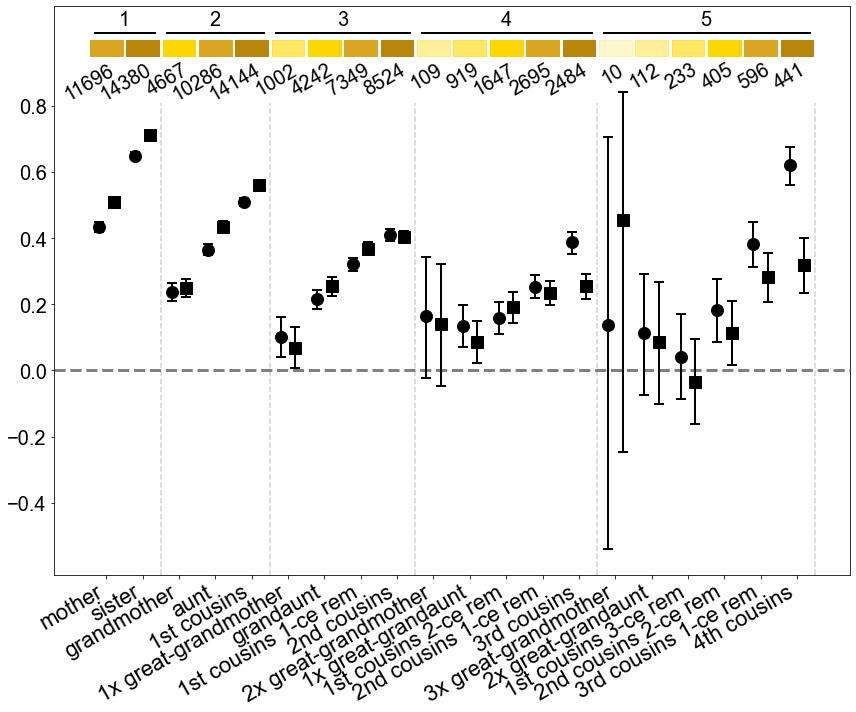

In [12]:
_ = plt.figure(figsize=(12, 10))
plt.errorbar([item - 0.2 for item in range(len(pairs))], pear, 
             yerr=([i - j for i, j in zip(pear, lower_p)], [i - j for i, j in zip(upper_p, pear)]), 
             marker='o', markersize=12, color='black', linewidth=0, ecolor='black', elinewidth=2, capsize=5, capthick=2.0, 
             label="Pearson Correlation Coefficient ± 95% Confidence Interval")
plt.errorbar([item + 0.2 for item in range(len(pairs))], spea, 
             yerr=([i - j for i, j in zip(spea, lower_s)], [i - j for i, j in zip(upper_s, spea)]), 
             marker='s', markersize=12, color='black', linewidth=0, ecolor='black', elinewidth=2, capsize=5, capthick=2.0, 
             label="Spearman Correlation Coefficient ± 95% Confidence Interval")

x1, x2 = -0.45, 0.45
for colour, alpha, pair in zip(colours, alphas, pairs):
    plt.fill_betweenx(y=[0.95, 1.0], x1=x1, x2=x2, color=colour, alpha=alpha, zorder=0)
    plt.text(x=x1+0.78, y=0.94, s=str(pair), horizontalalignment='right', verticalalignment='top', rotation=30, fontname="Arial", fontsize=20)
    x1 += 1.0
    x2 += 1.0

x1, x2 = -0.35, 1.35
for i in range(5):
    plt.fill_betweenx(y=[1.020, 1.023], x1=x1, x2=x2, color="black", alpha=alpha, zorder=0)
    plt.text(x=x1+(x2-x1)/2, y=1.06, s=str(i+1), fontname="Arial", fontsize=20, horizontalalignment='center', verticalalignment='center')
    plt.axvline(x=x2+0.15, ymax=0.83, color="lightgrey", linestyle="dashed", zorder=0)
    x1 += i + 2
    x2 += i + 3

plt.axhline(y=0, color="grey", linestyle="dashed", linewidth=3.0, zorder=0)
plt.xticks(list(range(len(names))), [f"{name}" for name, pair in zip(names, pairs)], horizontalalignment='right', verticalalignment='top', rotation=30, fontname="Arial", fontsize=22)
plt.yticks([item / 10 for item in range(-4, 9, 2)], fontname="Arial", fontsize=20)

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.tight_layout()
plt.show()


## Perform linear regression on the correlation coefficients to express the dumpening effect:

In [22]:
gen_dist = ((pear[0:2], spea[0:2]), (pear[2:5], spea[2:5]), (pear[5:9], spea[5:9]), (pear[9:14], spea[9:14]), (pear[14:20], spea[14:20]))
pair_cnt = (data_pairs[0:2], data_pairs[2:5], data_pairs[5:9], data_pairs[9:14], data_pairs[14:20])

slope_list = [[] for _ in range(2)]
intercept_list = [[] for _ in range(2)]

for e, ((p, s), pair) in enumerate(zip(gen_dist, pair_cnt)):
    print (f"Common nearest depth: {e+1} -> Pear: {[round(item, 3) for item in p]}; Spea: {[round(item, 3) for item in s]}")

    for ee, (coef, clr, lab) in enumerate(zip([p, s], ["dodgerblue", "forestgreen"], ["Pearson", "Spearman"])):

        # Regress Linear Fit & Find the Slopes:
        if coef != []:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x=range(len(coef)),y=coef)
            slope_list[ee].append(slope)
            intercept_list[ee].append(intercept)

            print (f"{lab}: slope = {slope} intercept = {intercept}")


Common nearest depth: 1 -> Pear: [0.434, 0.65]; Spea: [0.51, 0.714]
Pearson: slope = 0.21636325761237485 intercept = 0.4337356562804886
Spearman: slope = 0.20392416263126056 intercept = 0.5096854774317578
Common nearest depth: 2 -> Pear: [0.238, 0.365, 0.509]; Spea: [0.251, 0.435, 0.56]
Pearson: slope = 0.1359296860522537 intercept = 0.23484830687013436
Spearman: slope = 0.1544516245036291 intercept = 0.2606761114608825
Common nearest depth: 3 -> Pear: [0.102, 0.216, 0.321, 0.41]; Spea: [0.069, 0.255, 0.368, 0.405]
Pearson: slope = 0.10276563720169599 intercept = 0.10810393034798016
Spearman: slope = 0.11227424666862788 intercept = 0.10569372598950588
Common nearest depth: 4 -> Pear: [0.166, 0.136, 0.159, 0.253, 0.387]; Spea: [0.142, 0.087, 0.191, 0.234, 0.255]
Pearson: slope = 0.05594514151291189 intercept = 0.10844171982835736
Spearman: slope = 0.03728454357386845 intercept = 0.10719244656464376
Common nearest depth: 5 -> Pear: [0.137, 0.113, 0.042, 0.183, 0.383, 0.621]; Spea: [0.455

### Plot the second subaxis to the same scale as the upper one: 

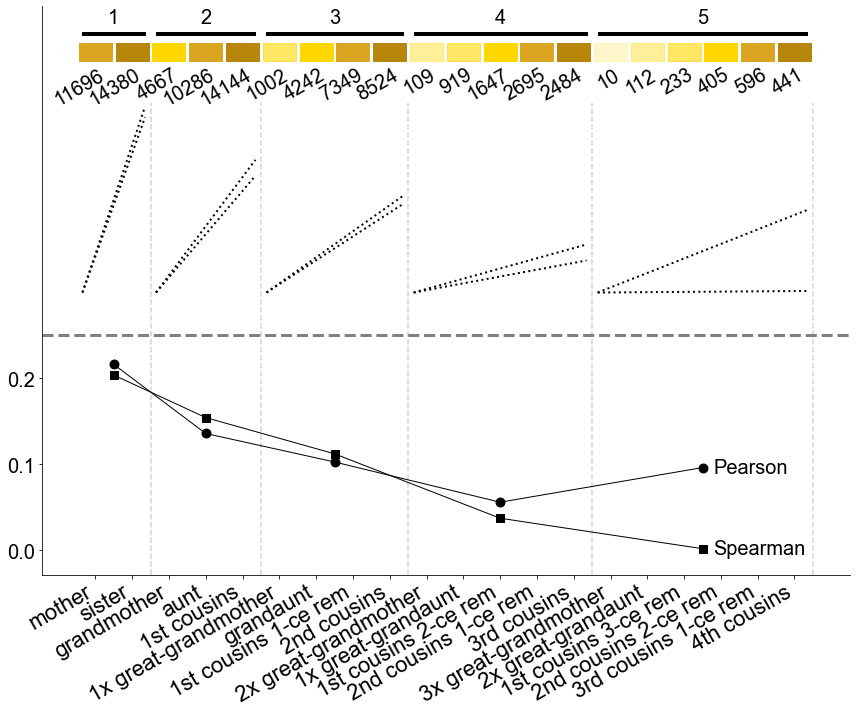

In [39]:
_ = plt.figure(figsize=(12, 10))

x_list = []

x1, x2 = -0.35, 1.35
for i in range(5):
    plt.fill_betweenx(y=[0.600, 0.603], x1=x1, x2=x2, color="black", alpha=alpha, zorder=0)
    plt.text(x=x1+(x2-x1)/2, y=0.62, s=str(i+1), fontname="Arial", fontsize=20, horizontalalignment='center', verticalalignment='center')
    plt.axvline(x=x2+0.15, ymax=0.83, color="lightgrey", linestyle="dashed", zorder=0)
    
    for corr_type, marker in zip(slope_list, ["o", "s"]):
        slp = corr_type[i]
        
        # Plot the linear regression lines:
        plt.plot([x1, x2], [0.3 + 0 * slp, 0.3 + 1 * slp], label=f"Slope: {slp}", linestyle="dotted", linewidth=2.0, color="black")
        
        # Plot the slope values:
        plt.scatter(x=x1+(x2-x1)/2, y=slp, marker=marker, s=80, color="black")
    
    # Increment:
    x_list.append(x1+(x2-x1)/2)
    x1 += i + 2
    x2 += i + 3

x1, x2 = -0.45, 0.45
for colour, alpha, pair in zip(colours, alphas, pairs):
    plt.fill_betweenx(y=[0.57, 0.59], x1=x1, x2=x2, color=colour, alpha=alpha, zorder=0)
    plt.text(x=x1+0.78, y=0.565, s=str(pair), horizontalalignment='right', verticalalignment='top', rotation=30, fontname="Arial", fontsize=20)
    x1 += 1.0
    x2 += 1.0

# Connect the slopes:
plt.plot(x_list, slope_list[0], color="black", linewidth=1.0, zorder=0)
plt.text(x=x_list[-1] + 0.3, y=slope_list[0][-1], s="Pearson", fontname="Arial", fontsize=20, horizontalalignment='left', verticalalignment='center')
    
plt.plot(x_list, slope_list[1], color="black", linewidth=1.0, zorder=0)
plt.text(x=x_list[-1] + 0.3, y=slope_list[1][-1], s="Spearman", fontname="Arial", fontsize=20, horizontalalignment='left', verticalalignment='center')


plt.axhline(y=0.25, color="grey", linestyle="dashed", linewidth=3.0, zorder=0)
plt.xticks(list(range(len(names))), [f"{name}" for name, pair in zip(names, pairs)], horizontalalignment='right', verticalalignment='top', rotation=30, fontname="Arial", fontsize=22)
plt.yticks([item / 10 for item in range(3)], fontname="Arial", fontsize=20)
#plt.tick_params(axis='y', which='both', labelleft=False, labelright=True, left=False, right=True)
#plt.title("Family Member Correlations")
#plt.legend(loc='center', ncol=2, fontsize=14)

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.tight_layout()
plt.show()


### Done!